# Generalization of functional relationships

In the last chapters we have learned about models that can be used for quantitative and categorical forecasting problems. The goal of modeling is always to represent the actual relationship between the independent variables $x_1, ..., x_p$ and a dependent variable $y$ as well as possible. So far, we have always used the entire dataset to train the models and have learned various metrics that can be used to determine the goodness of the models for the training data. Unfortunately, however, high model goodness for the training data does not necessarily result in high model goodness for new and unseen test data. If this is not successful, it cannot be assumed that a model represents the generally existing relationship between independent and dependent variables. Accordingly, it is important to always evaluate a model for new data not used in training the model. However, data is not available in arbitrary quantities, so usually a portion of the training data is used to evaluate out-of-sample performance rather than to estimate model parameters. In the following, we use the terms training and test error to refer to the goodness of a model for training and test data. 

## Simple split of the data

The simplest way to estimate the test error is to randomly split the entire data set and designate a portion to train the model and determine the training error, while determining the test error using the estimated model for the test data. In the next cell, we return to the Advertising data set from the linear regression chapter and randomly split the data into training and test data. Initially, we do this in equal proportions. The training data set is used to estimate the parameters of the linear regression model, and then we calculate the mean square error (MSE) of the training and test data. To get a sense of the variation in estimating the test error, we perform this procedure $100$ times. The graph below shows the histograms of the MSE of the training and test data sets. First, we notice that there is a slightly higher mean MSE in the test data set than in the training data set (vertical line). In addition, we also see that the variation of the MSE in the test data set is relatively high. This is problematic if we imagine that we would base our assessment of the model only on a random partitioning of the data. With the multiple splitting approach presented below, we do not have this problem, but the approach shown is critical for another reason. In our example, we split the data evenly, which results in only half of the data being able to be used to train the model. This increases the variance of the predictions from the model. In addition, more complex models require more data to learn more complex relationships. If we reduce the amount of test data, this also increases the variation of the test error, but the resulting disadvantage can be reduced by using the multiple draw procedure as presented below. Only one small problem remains. If we randomly split the data each time, the estimated average test error will vary. Therefore, cross-validation, and especially k-fold cross-validation, is often preferred to the procedure shown here.

```{note}
Note: There are several packages in Python, some of which can be used for the same purpose as estimating statistical models. For example, various regression models can be estimated with both the statsmodels and scikit-learn packages. While the statsmodels package has a more traditional statistical background and accordingly many metrics are output for statistical inference, the scikit-learn package often has useful routines from the machine learning domain. We always use packages that are best suited for the methods presented.
```

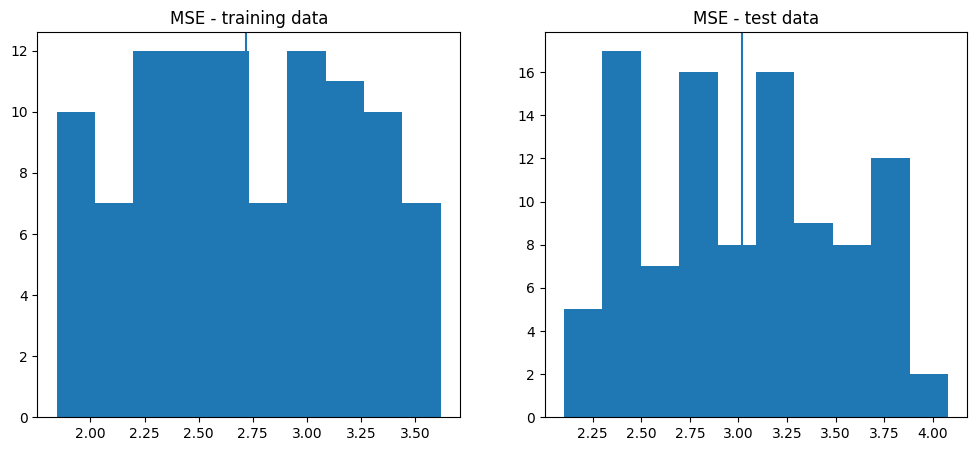

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt


advertising_df = pd.read_csv("../data/Advertising.csv", index_col= "Unnamed: 0")

draws = 100
mse_train_results, mse_test_results = [], []
for _ in range(draws):

    train_df = advertising_df.sample(frac = 0.50, replace=False)
    test_df = advertising_df.loc[[idx for idx in advertising_df.index if not(idx in train_df.index)], :]

    X_train, X_test = train_df.drop(["sales"], axis = 1), test_df.drop(["sales"], axis = 1)
    y_train, y_test = train_df.sales, test_df.sales

    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    y_train_hat, y_test_hat = linear_regression.predict(X_train), linear_regression.predict(X_test)

    mse_train, mse_test = mean_squared_error(y_train, y_train_hat), mean_squared_error(y_test, y_test_hat)
    mse_train_results.append(mse_train)
    mse_test_results.append(mse_test)


fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].hist(mse_train_results)
axs[0].axvline(np.mean(mse_train_results))
axs[0].set_title("MSE - training data")

axs[1].hist(mse_test_results)
axs[1].axvline(np.mean(mse_test_results))
axs[1].set_title("MSE - test data")
plt.show()

## K-fold cross validation

In K-fold cross validation, the data set is split into $k$ equal parts. Then, one of the parts is used as a test data set at a time, while the remaining data is used to train the model. This process is performed $k$ times by iterating over all the parts (folds). The graph below visualizes this form of data partitioning.

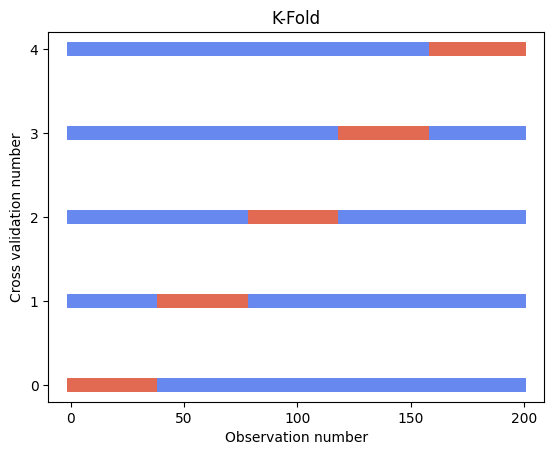

In [2]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

cmap_cv = plt.cm.coolwarm
n_splits = 5
cv = KFold(n_splits)


advertising_df = pd.read_csv("../data/Advertising.csv", index_col= "Unnamed: 0")
X = advertising_df.drop(["sales"], axis = 1)
y = advertising_df.sales

fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=10,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )


ax.set_xticks(np.arange(0, 201, 50))
ax.set_yticks(np.arange(n_splits)+0.5)
ax.set_yticklabels([i for i in range(n_splits)])

ax.set_xlabel("Observation number")
ax.set_ylabel("Cross validation number")
ax.set_title("K-Fold")

plt.show()

After each iteration we have an estimator of a test error, for example for a regression problem the $MSE_k = \frac{1}{n_k} \sum_{i \in k_{\text{fold}}} \left(y_i - \hat{y}_i\right)^2 $. As a final estimator of the test error, we can use the average test error over all k-folds:

$$
CV_{(k)} = \frac{1}{k} \sum_k MSE_k
$$

In the next cell, K-fold cross-validation is performed for the Advertising data set with $k=5$. Since the number of observations of the test data is smaller than in the upper sampling method, the individual estimates $MSE_k$ of the test data vary more. However, we see that the actual estimator $CV_{(k)}$ takes a very similar value as in the upper example. In addition, more data can be used to train the model.

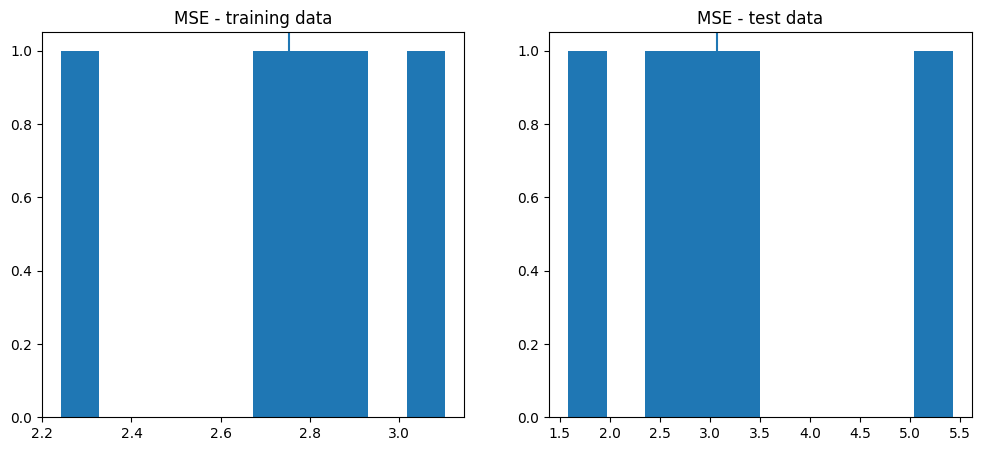

In [3]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


advertising_df = pd.read_csv("../data/Advertising.csv", index_col= "Unnamed: 0")
advertising_df.reset_index(drop = True, inplace = True)
X = advertising_df.drop(["sales"], axis = 1)
y = advertising_df.sales

n_splits = 5
cv = KFold(n_splits)

mse_train_results, mse_test_results = [], []
for ii, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.loc[train_idx, :], X.loc[test_idx, :]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    y_train_hat, y_test_hat = linear_regression.predict(X_train), linear_regression.predict(X_test)
    
    mse_train, mse_test = mean_squared_error(y_train, y_train_hat), mean_squared_error(y_test, y_test_hat)
    mse_train_results.append(mse_train)
    mse_test_results.append(mse_test)

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].hist(mse_train_results)
axs[0].axvline(np.mean(mse_train_results))
axs[0].set_title("MSE - training data")

axs[1].hist(mse_test_results)
axs[1].axvline(np.mean(mse_test_results))
axs[1].set_title("MSE - test data")
plt.show()

Furthermore, one should be careful when interpreting the histograms in the cell above. It is precisely the advantage of cross-validation that we would not evaluate the model on the basis of the individual test errors, but on their average. If we were to perform this procedure multiple times, the variation in the estimated values for $CV_{(k)}$ would be much smaller than with the method of simply splitting the data. To demonstrate this, we forgo for a moment the reproducibility of the value for $CV_{(k)}$ and perform the cross-validation with $k=5$ multiple times by randomly splitting the parts of the data after all. We then consider the histogram for all realizations of $CV_{(k)}$ over all K-fold runs. Here it becomes clear that the assessment of a model based on K-fold validation varies significantly less with different (random) splits of training and test data. This is exactly the advantage, since the evaluation of the generalization ability of a model is more stable with respect to the drawing of random training and test data. 

In the type of cross-validation presented here, it is assumed that the observations of the data have no dependencies on each other. This assumption is violated if observations have geographic, temporal, or other types of dependencies. For example, for time series data, it can be problematic if future data can be used to forecast past data because of the way the fold is formed. This can result in systematic misestimates of model quality, so such relationships are adjusted as needed. However, this must be done specifically depending on the problem.

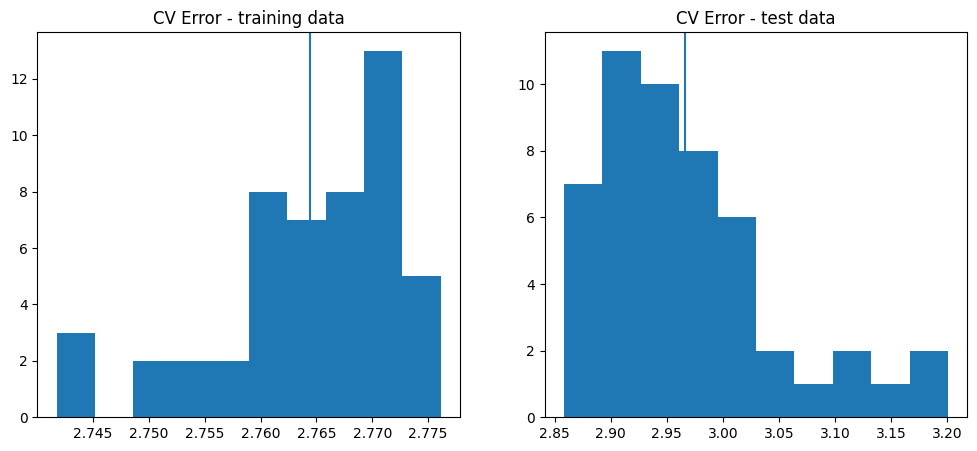

In [4]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


advertising_df = pd.read_csv("../data/Advertising.csv", index_col= "Unnamed: 0")
advertising_df.reset_index(drop = True, inplace = True)
X = advertising_df.drop(["sales"], axis = 1)
y = advertising_df.sales

n_splits = 5
n_fold_runs = 50

mse_train_cv, mse_test_cv = [], []
for fold_run in range(n_fold_runs):
    cv = KFold(n_splits, shuffle = True)
    mse_train_results, mse_test_results = [], []
    for ii, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.loc[train_idx, :], X.loc[test_idx, :]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        
        linear_regression = LinearRegression()
        linear_regression.fit(X_train, y_train)
        y_train_hat, y_test_hat = linear_regression.predict(X_train), linear_regression.predict(X_test)
        
        mse_train, mse_test = mean_squared_error(y_train, y_train_hat), mean_squared_error(y_test, y_test_hat)
        mse_train_results.append(mse_train)
        mse_test_results.append(mse_test)
    mse_train_cv.append(np.mean(mse_train_results))
    mse_test_cv.append(np.mean(mse_test_results))

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].hist(mse_train_cv)
axs[0].axvline(np.mean(mse_train_cv))
axs[0].set_title("CV Error - training data")

axs[1].hist(mse_test_cv)
axs[1].axvline(np.mean(mse_test_cv))
axs[1].set_title("CV Error - test data")
plt.show()